*Z-Score:*
$$
Z = \frac{\bar{x_{1}}+\bar{x_{2}}}{\sqrt{\frac{s^{2}_{1}}{N_{1}} + \frac{s^{2}_{2}}{N_{2}}}}
$$


*$\chi^{2}$ Function:*
$$
\chi^{2} = \sum_{i}\frac{(y_{i} - y(h_{i}))^{2}}{\sigma ^{2}}
$$

*Correlation Coefficient:*
$$
r = \frac{\vec{A}\vec{B}}{|A||B|}
$$

*Potential Model:*
$$
R(h) = R_{1}exp[(-h1 - h)/H]
$$

In [12]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
class location_data:
    def __init__(self,location,data,location_type = None):
        self.location = location
        self.data = data
        self.location_type = location_type

    def display_location(self):
        print(self.location, self.location_type)


class comparison_data:
    def __init__(self,location_data_1,location_data_2,Z_score,Chi,r):
        self.location_data_1 = location_data_1
        self.location_data_2 = location_data_2
        self.Z_score = Z_score
        self.Chi = Chi
        self.r = r

    def export_format(self):
        export_array = [
            [f"{self.location_data_1.location}",f"{self.location_data_2.location}"],
            ["=====================","====================="],
            ["Test","Value"],
            ["---------------------","---------------------"],
            ["Z-Score",f"{self.Z_score:.2f}"],
            ["Chi Sqrd",f"{self.Chi:.2f}"],
            ["Correlation Coefficient", f"{self.r}"],
            ["---------------------","---------------------"],
            ["",""]
            ]
        return export_array
        

c:\Users\slick\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


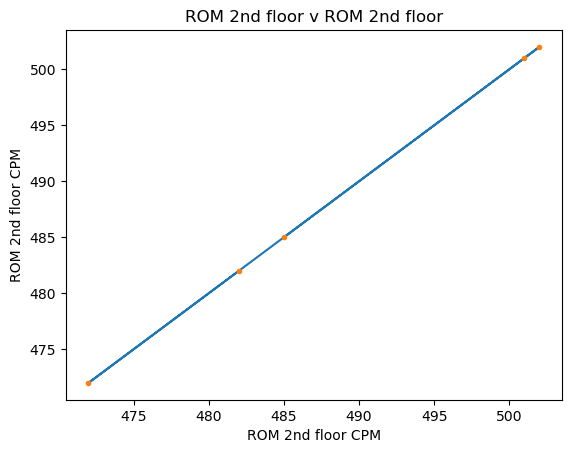

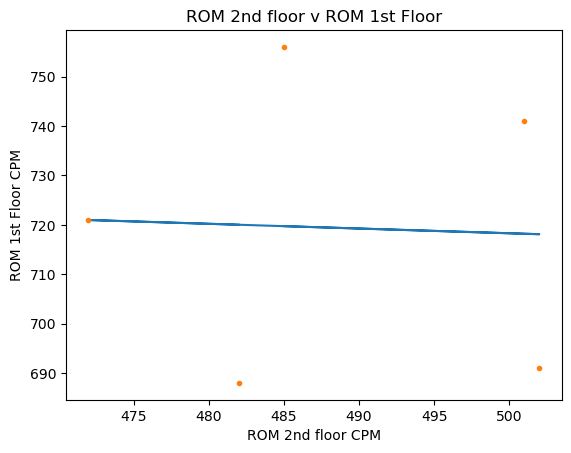

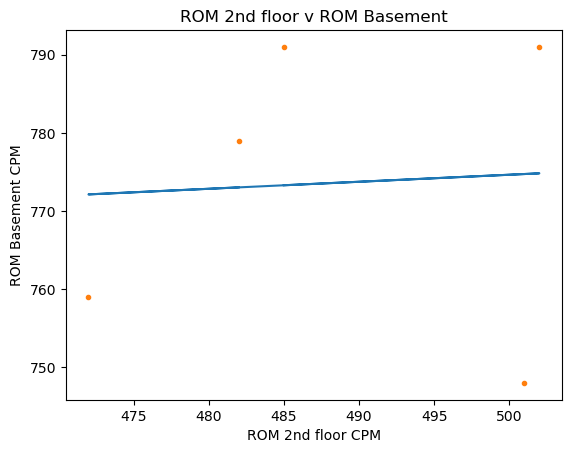

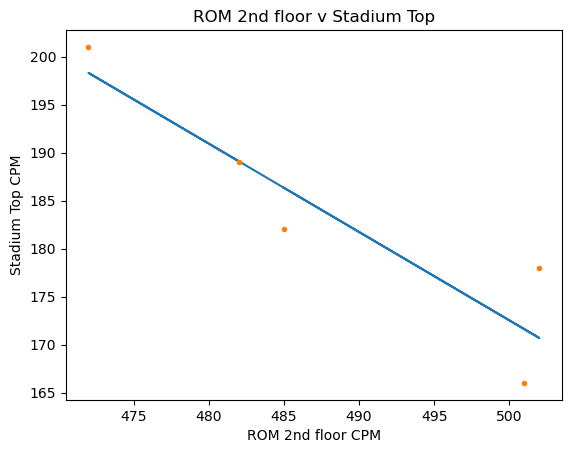

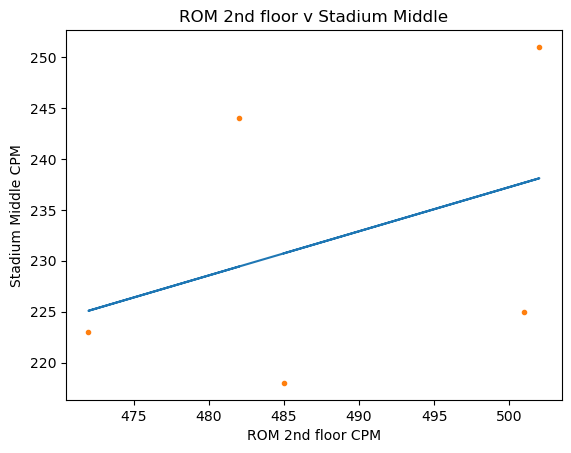

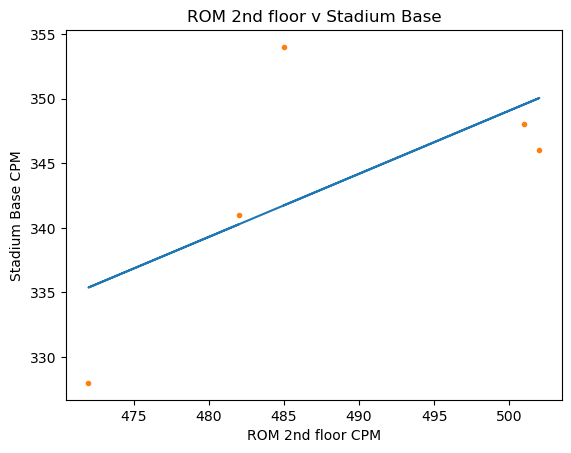

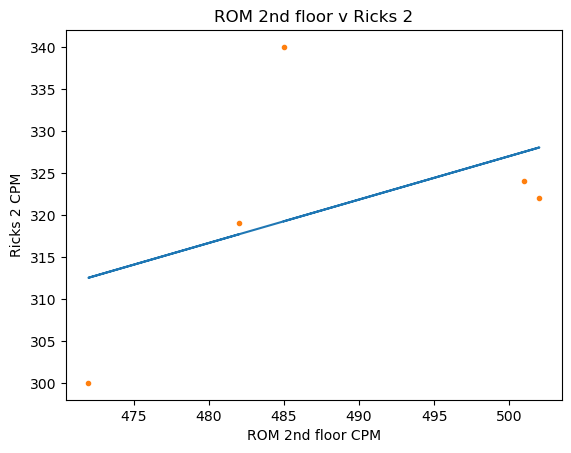

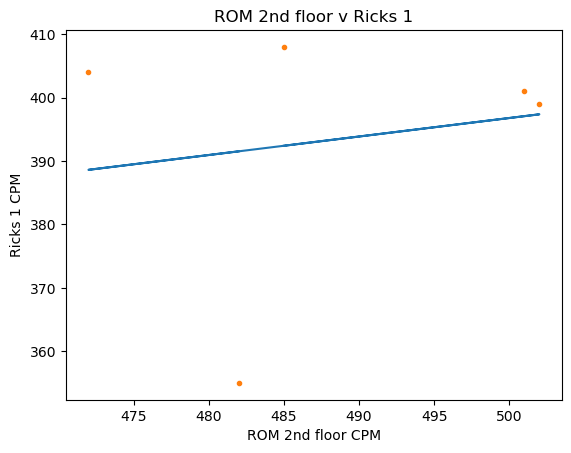

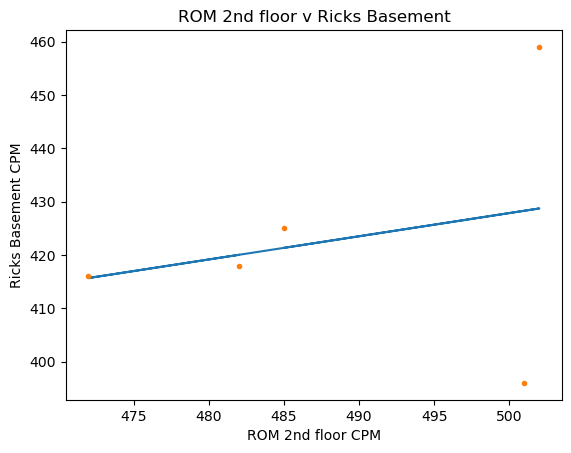

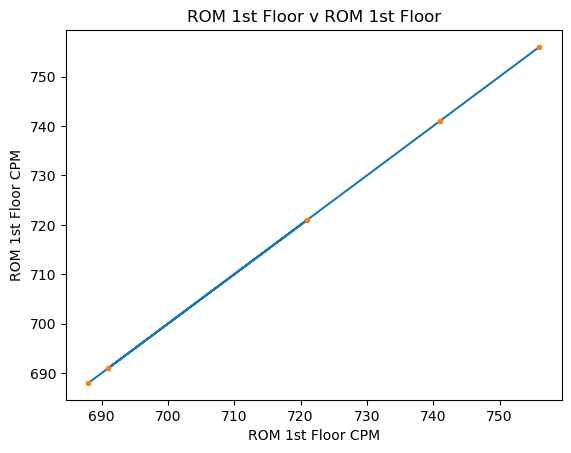

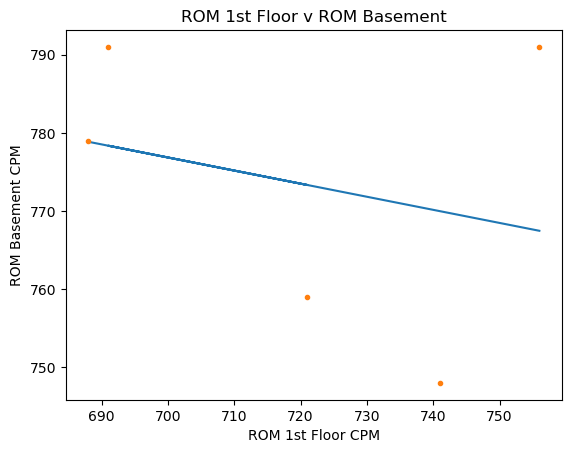

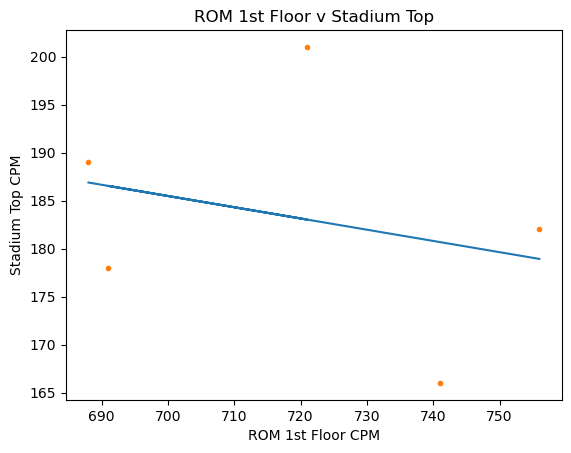

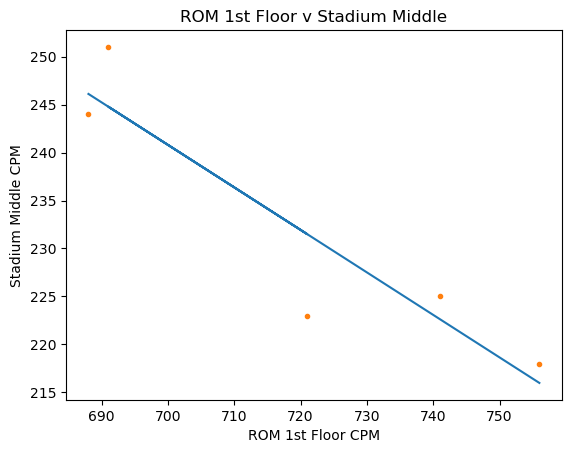

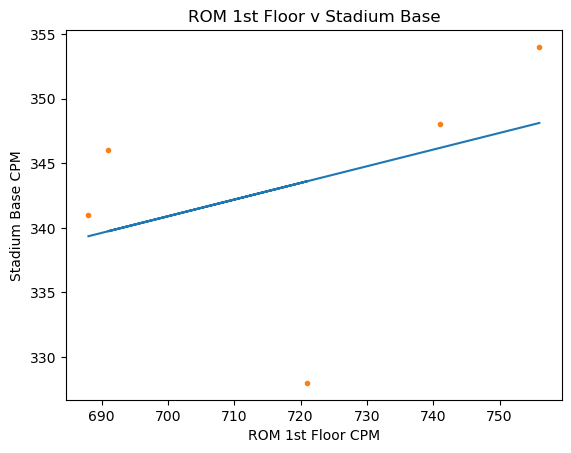

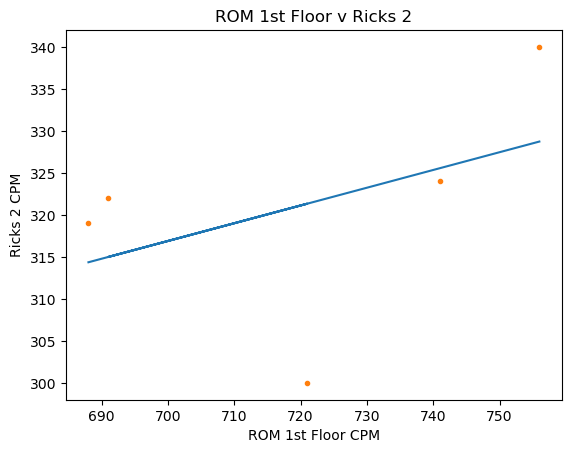

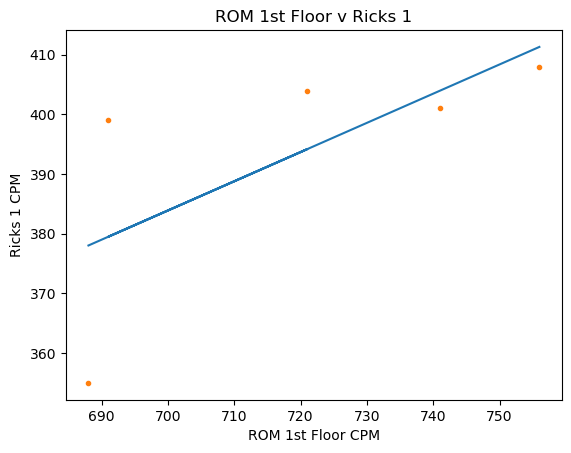

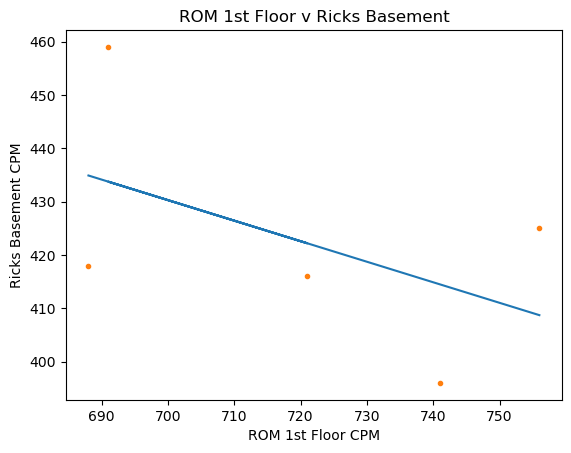

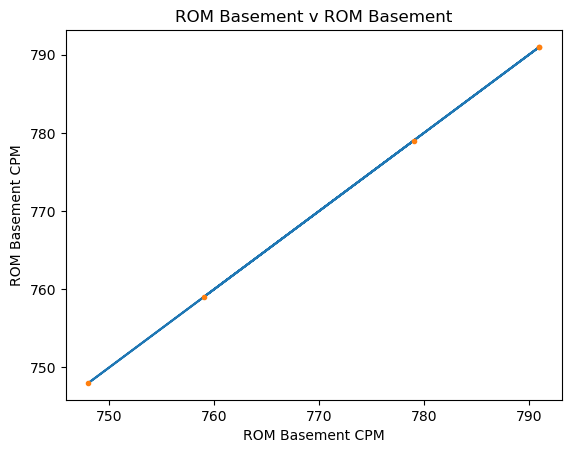

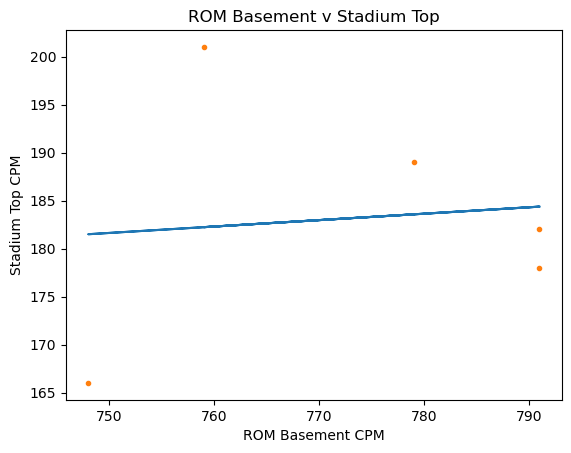

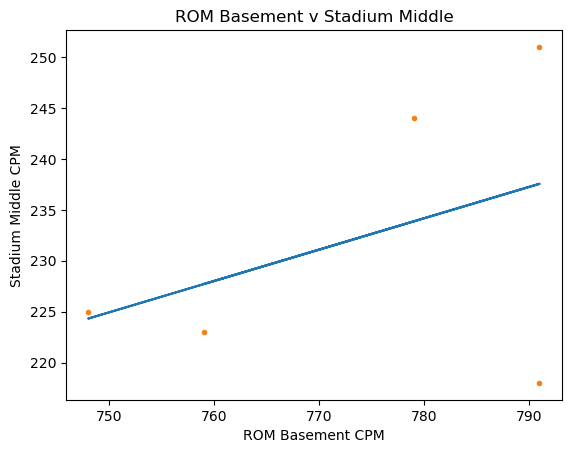

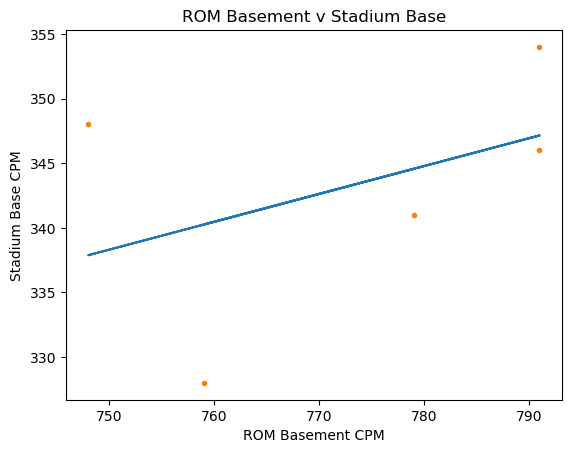

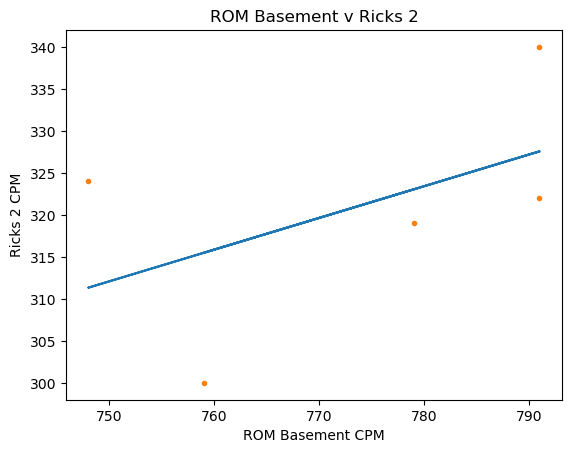

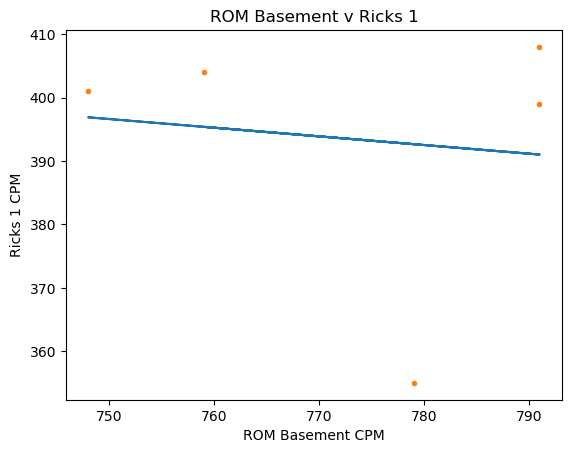

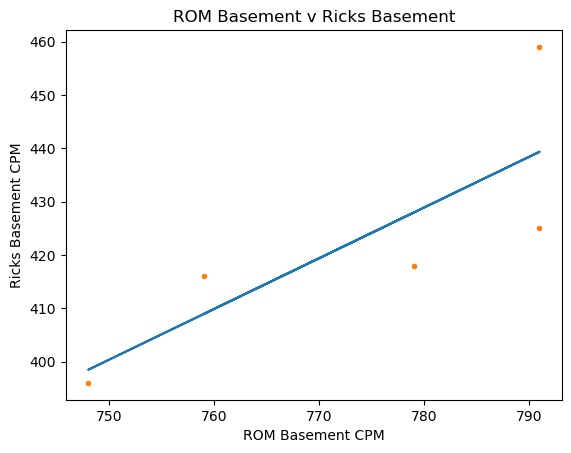

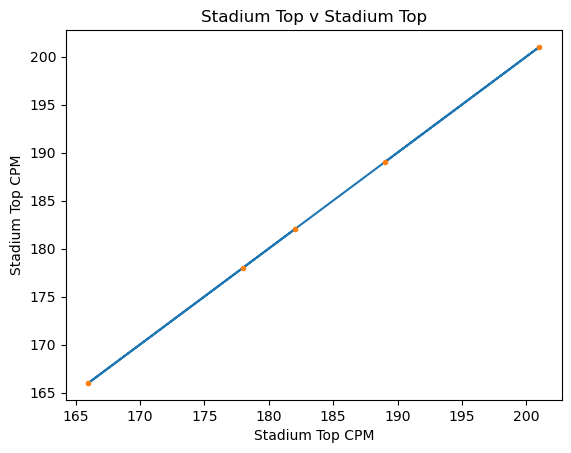

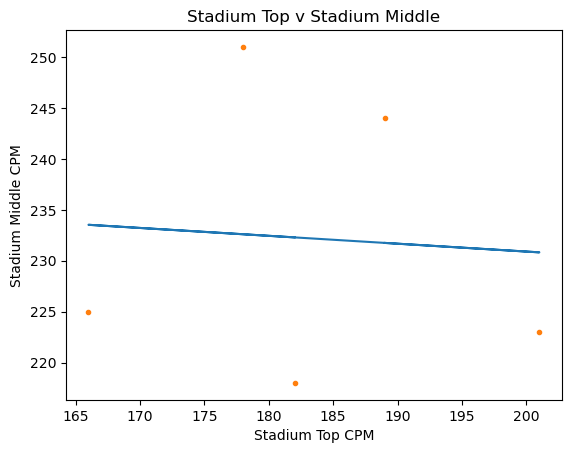

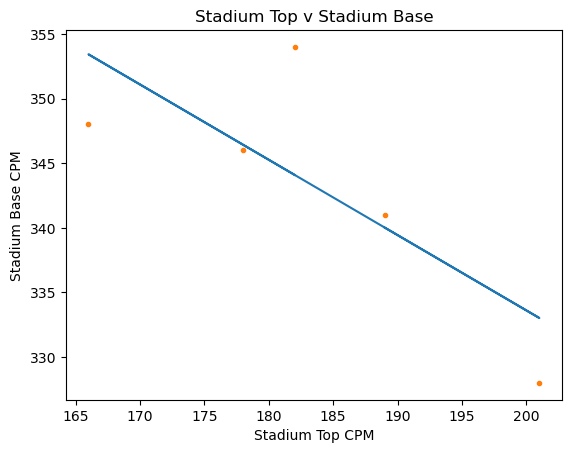

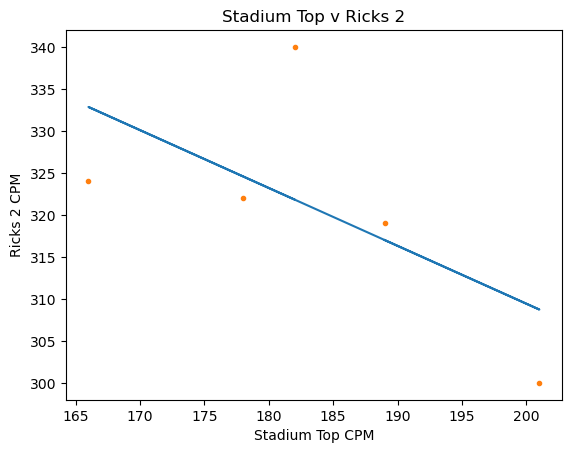

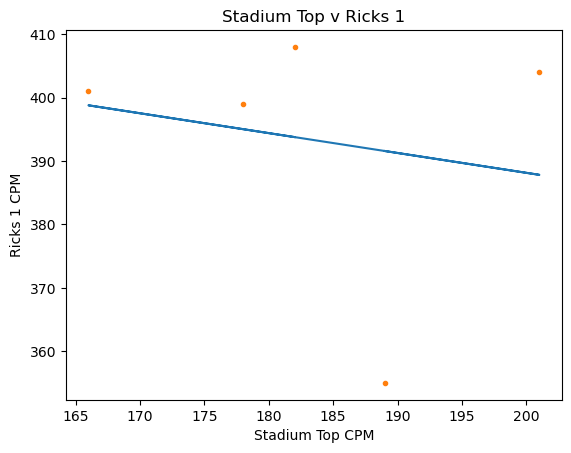

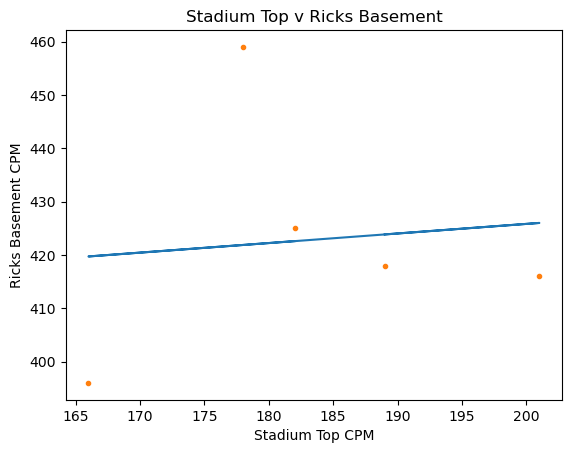

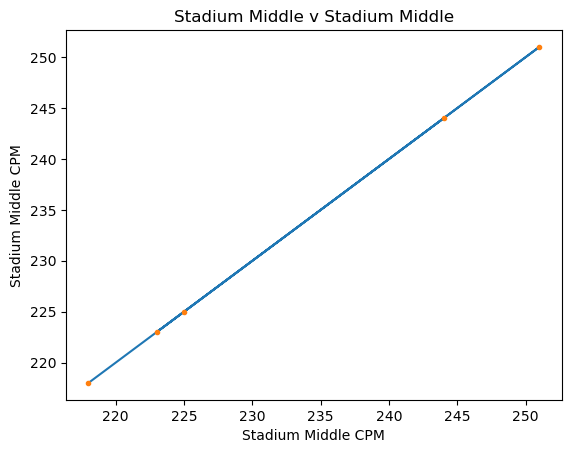

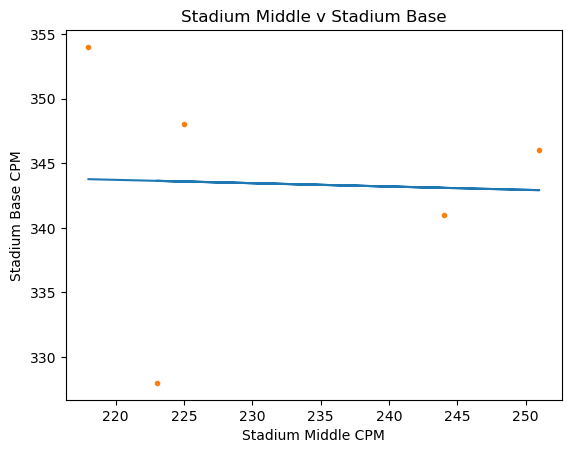

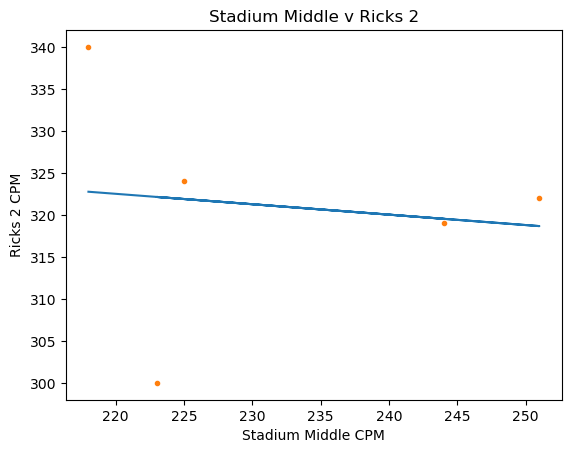

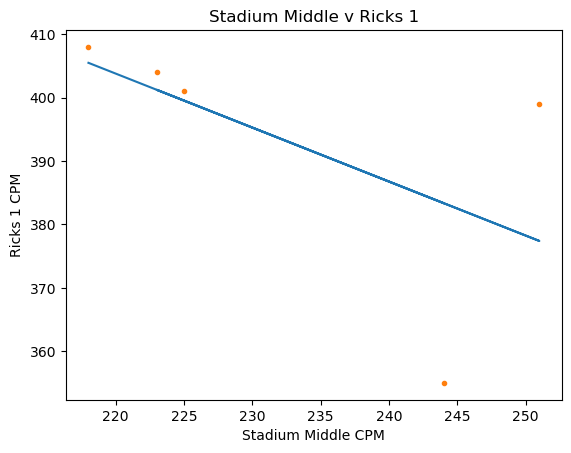

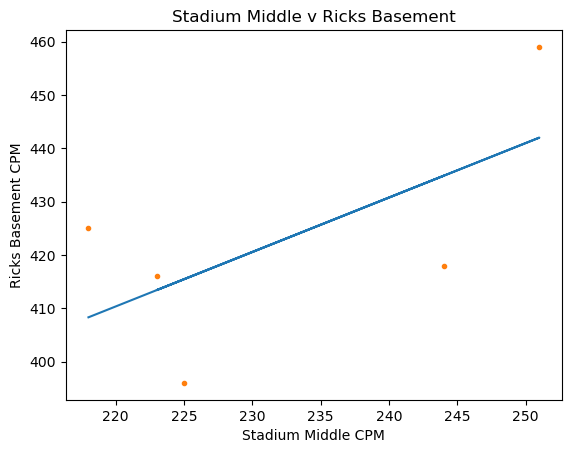

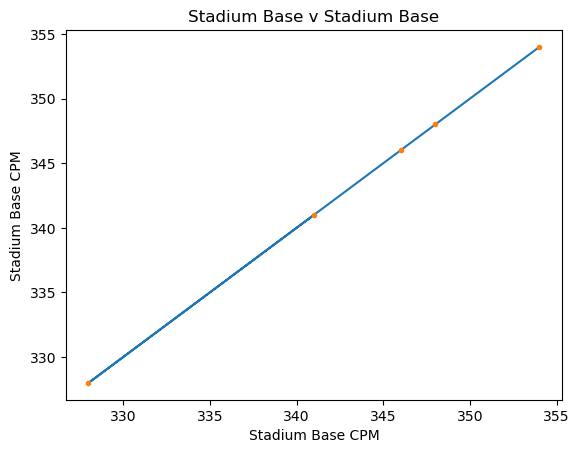

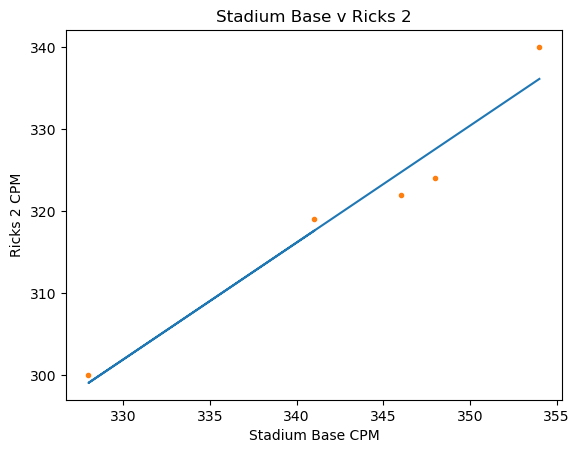

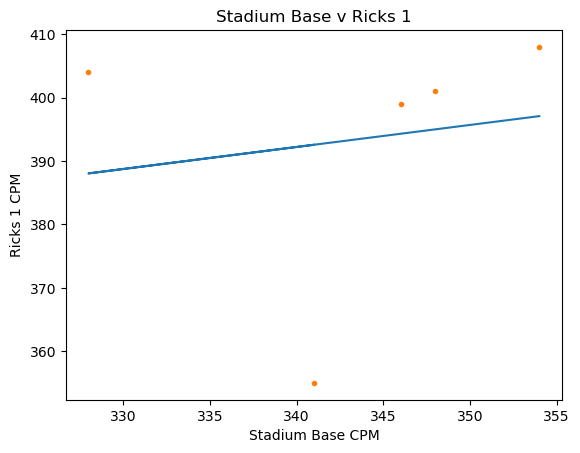

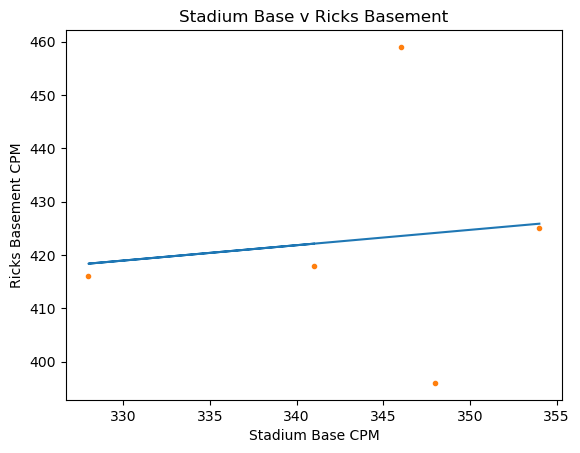

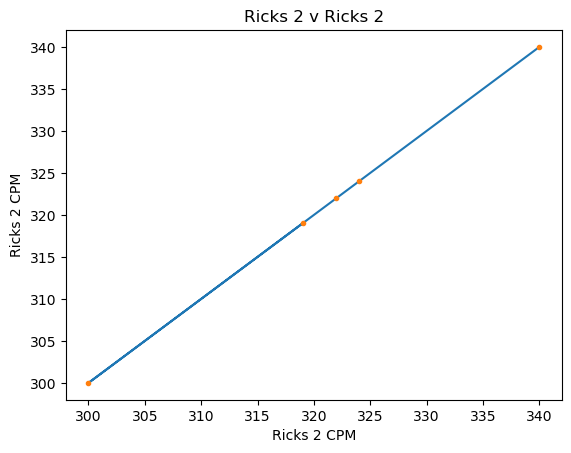

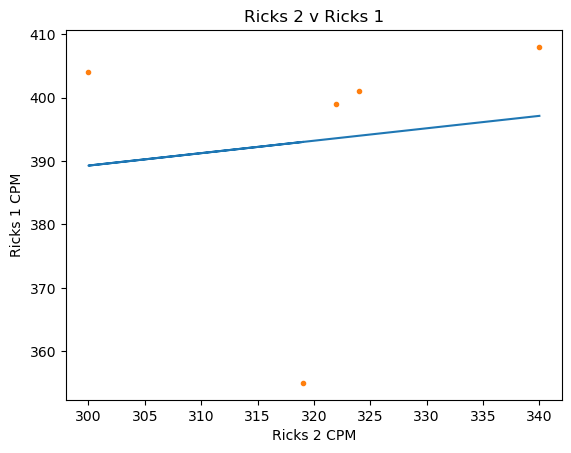

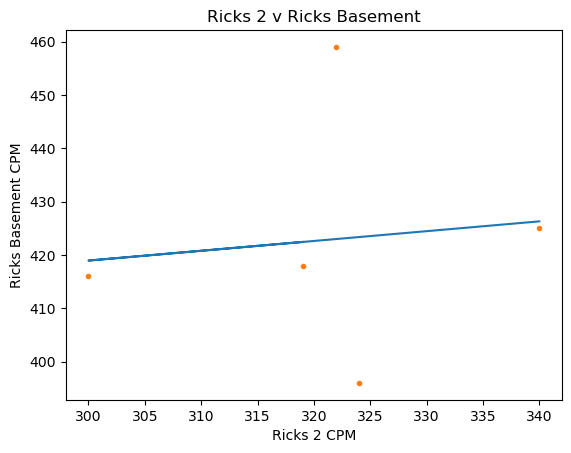

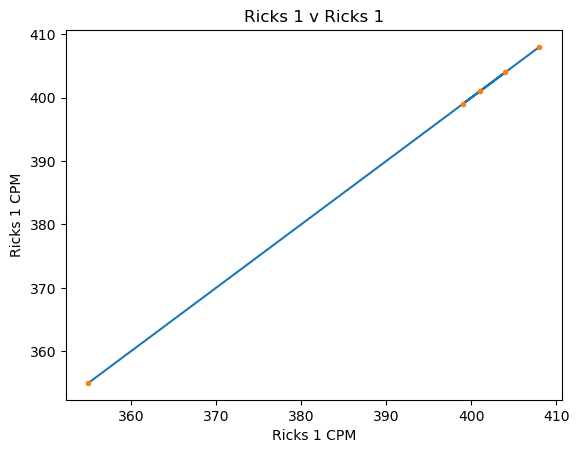

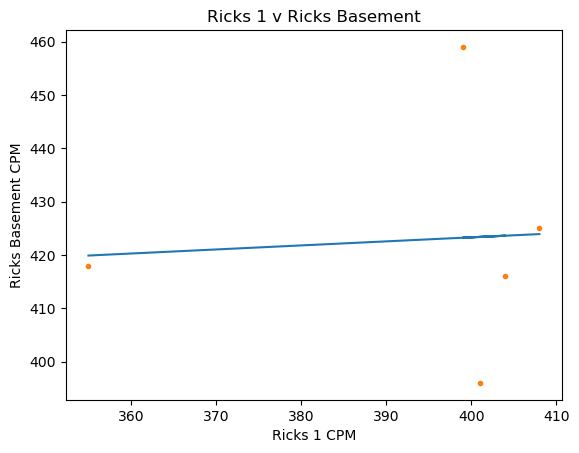

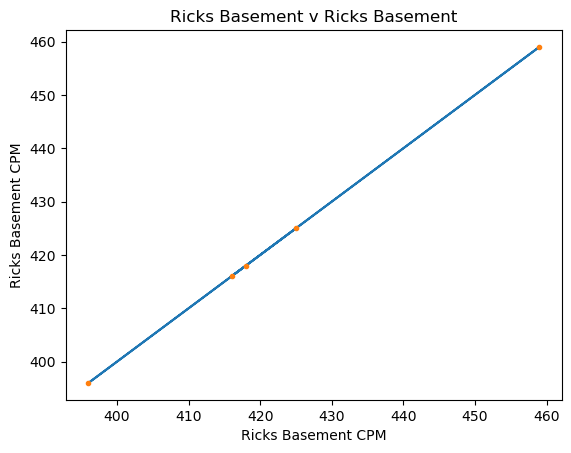

In [16]:
#Open and read from file
def read_from_file(file_name):
    """Function reads our data from our file and transforms it into
    a numpy array, which we return.
    Parameters: 
      file_name
    Return: 
      file_data as a numpy array
    """
    data = pd.read_csv(file_name,encoding='unicode_escape')
    #file_data = data.to_numpy()
    return data

#Parse through and return list of location data
def parse_file_data(file_data):
    """ Function parses file_data and splits it into classes, then appends
    it to a list.
    Parameters:
        file_data (numpy array)
    Return:
        list of location_data objects
    """
    #Create new blank list
    location_data_list = []

    #Parse through file_data
    index = file_data.index[file_data["Comment"].notna()]

    for idx in index:
        data = []
        location = str(file_data["Real time"][idx])
        location_type = str(file_data["Comment"][idx])

        #Sort through the data and remove the CPM from each
        for strings in np.array(file_data["Count rate"][idx+1:idx+6]).astype(str):
            data.append(strings.split(" ")[0])
        
        #Convert the data to a nparray
        data = np.array(data).astype(float)

        #Create a new location data object and append to array
        local_data = location_data(location,data,location_type)
        location_data_list.append(local_data)
    return location_data_list

def compare_data(location_data_list): #Ignore for now
    """Function takes the list of location_data and parses through 
    and compares it against the other values.
    Parameters:
        List of location_data objects
    Returns:
        uhhhhhhhhh...... 
    """
    compared_data_list = []
    #Another loop function, this time not double counting units
    for i in range(len(location_data_list)):
        x1_array = location_data_list[i].data
        for j in range(i,len(location_data_list)):
            x2_array = location_data_list[j].data
            sigma = np.sqrt(x1_array*x2_array)

            z_score = ZScore(x1_array,x2_array)
            chi_sqrd = Chi_sqrd(x1_array,x2_array,sigma)   #NEED TO FIX SIGMA!!!
            r = correlation_coefficient(x1_array,x2_array)

            #plt.plot(x1_array,x2_array,'.')
            #plt.show()

            compared_data = comparison_data(location_data_list[i],location_data_list[j],z_score,chi_sqrd,r)
            compared_data_list.append(compared_data)

    return compared_data_list
    
def export_data_to_csv(export_file,data_list):
    #Clear the old file
    clear_list = []
    df = pd.DataFrame(clear_list)
    pd.DataFrame.to_csv(df,export_file,header= False,index=False,mode='w')

    #Convert list of lists to Pandas dataframe
    for export_data in data_list:
        df = pd.DataFrame(export_data.export_format())
        pd.DataFrame.to_csv(df,export_file,header= False,index=False,mode='a')

def mean(x_array):
    N = len(x_array)
    return sum(x_array)/N

def stdev(x_array):
    x_mean = mean(x_array)
    stdev_x = 0
    N = len(x_array)
    for x in x_array:
        stdev_x += (x-x_mean)**2
    return np.sqrt((stdev_x)/(N-1))

#Def Zscore test
def ZScore(x1_array,x2_array):
    #Calculate the number of values in both arrays
    N1 = len(x1_array)
    N2 = len(x2_array)

    #Calculate the mean of both arrays
    x1_mean = mean(x1_array)
    x2_mean = mean(x2_array)

    #Calculate the Stdev of both arrays
    stdev_x1 = stdev(x1_array)
    stdev_x2 = stdev(x2_array)

    #Calculate and return our Z-Score
    return (x1_mean - x2_mean)/(np.sqrt((stdev_x1*stdev_x1/N1) + (stdev_x2 * stdev_x2/N2)))

def correlation_coefficient(x1_array,x2_array):
    #Define A and B
    A = x1_array - mean(x1_array)
    B = x2_array - mean(x2_array)

    #Find our magnitudes for A and B
    Amag = np.linalg.norm(A)
    Bmag = np.linalg.norm(B)

    #Calculate and return our correlation coefficient
    r = A@B/(Amag*Bmag)
    return r

def Chi_sqrd(x1_array,x2_array,sigma):
    # Calculate our Chi squared value
    chi_sqrd = sum((x1_array-x2_array)*(x1_array-x2_array)/sigma/sigma)
    return chi_sqrd

def y(x,b,m):
    return m*x + b

def PlotData(compared_data_list):
    for compared_data in compared_data_list:
        x1_array = compared_data.location_data_1.data
        x2_array = compared_data.location_data_2.data


        coeff,discard = curve_fit(y,x1_array,x2_array)
        m = coeff[0]
        b = coeff[1]
        y_points = []
        for x in x1_array:
            y_points.append(y(x,m,b))

        plt.title(f"{compared_data.location_data_1.location} v {compared_data.location_data_2.location}")
        plt.xlabel(f"{compared_data.location_data_1.location} CPM")
        plt.ylabel(f"{compared_data.location_data_2.location} CPM")
        plt.plot(x1_array,y_points)
        plt.plot(x1_array,x2_array,'.')
        plt.show()

def main():
    #Pull data from file and parse it into classes
    file_name = "PH 336 SDL ROM 2 2024-03-20.csv"
    file_data = read_from_file(file_name)
    location_data_list = parse_file_data(file_data)
    compared_data_list = compare_data(location_data_list)

    PlotData(compared_data_list)

    #display_data()
    export_data_to_csv("compared_data.csv",compared_data_list)

main()